# `elec-00`: ERP analysis
This lab introduces epoching and event-related potential (ERP) analysis using MNE. We will apply the ERP analysis to EEG responses to visual and auditory stimuli.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Example data and events
We'll load in our preprocessed EEG data acquired while participants were presented with auditory and visual stimuli.

In [2]:
from mne.io import read_raw_fif

# Load preprocessed data
raw_fn = '../elec-00/sub-01_task-audvis_preproc_raw.fif'
raw = read_raw_fif(raw_fn, preload=True, verbose=False)

In addition to the EEG and peripheral channels, our recording includes trigger (i.e. stimulus) channels. Trigger channels mark the onset/offset of events during recording. In our recording in particular, STI 014 is the trigger channel that was used for combining all the events to a single channel. It has several pulses of different amplitude throughout the recording. These pulses correspond to different stimuli presented to the subject during the acquisition. The pulses and their corresponding events are defined in the table below.

| Name   | #  | Contents                                |
|--------|----|-----------------------------------------|
| LA     | 1  | Response to left-ear auditory stimulus  |
| RA     | 2  | Response to right-ear auditory stimulus |
| LV     | 3  | Response to left visual field stimulus  |
| RV     | 4  | Response to right visual field stimulus |
| Smiley | 5  | Response to the smiley face             |
| Button | 32 | Response triggered by the button press  |

These are the events to which we'll align our epochs. To create an event list from raw data, we'll use a dedicated function. Since the event list is simply a numpy array, you can also manually create one. If you create one from an outside source (like a separate file of events), pay special attention to aligning the events correctly with the raw data.

In [3]:
from mne import find_events
from mne.viz import plot_events

# Extract events
events = find_events(raw)
print(events[:5])

320 events found on stim channel STI 014
Event IDs: [ 1  2  3  4  5 32]
[[27977     0     2]
 [28345     0     3]
 [28771     0     1]
 [29219     0     4]
 [29652     0     2]]


The event list contains three columns. The first column corresponds to sample number. To convert this to seconds, you must divide the sample number by the sampling frequency. The second column is reserved for the old value of the trigger channel at the time of transition, but is currently not in use. The third column is the trigger ID (amplitude of the pulse). To get a better picture of the task design, we'll plot out the events. First we'll construct a Python dictionary matching event labels to event integers.

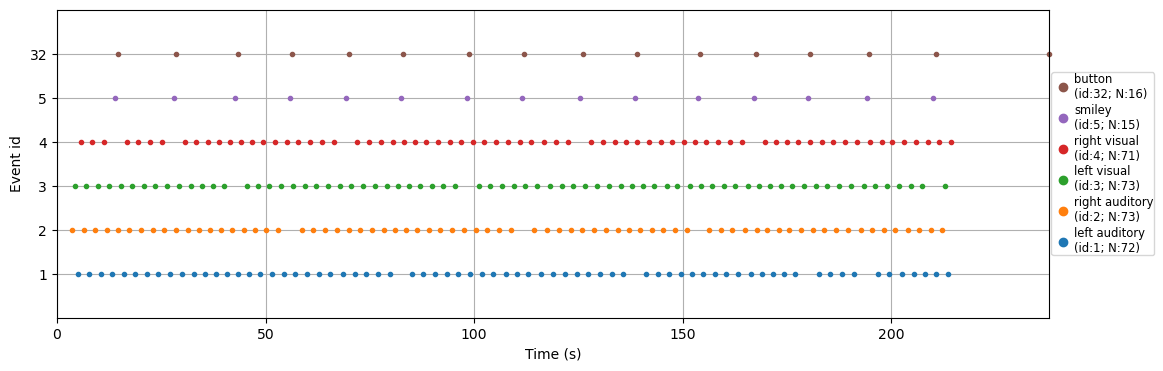

In [4]:
# Plot events
event_id = {'left auditory': 1, 'right auditory': 2, 'left visual': 3, 'right visual': 4,
             'smiley': 5, 'button': 32}

fig, ax = plt.subplots(1,1,figsize=(16,4))
color = {1: '#1f77b4', 2: '#ff7f0e', 3: '#2ca02c', 4: '#d62728', 5: '#9467bd', 32: '#8c564b'}
plot_events(events, raw.info['sfreq'], raw.first_samp, color=color, event_id=event_id, axes=ax);

### Epoching

Epoching describes the process of taking snapshots (i.e. windows) of the data centered around some event of interest. We will perform epoching using the MNE `Epochs` class. To do so, we need to define some parameters for our epoching. In this tutorial we are only interested in triggers 1, 2, 3 and 4. These triggers correspond to auditory and visual stimuli. The `event_id` here can be an integer, a list of integers or a dictionary. With dictionaries, it's possible to assign these IDs to distinct categories.

In [5]:
# Redefine events of interest
event_id = {'left auditory': 1, 'right auditory': 2,
            'left visual': 3, 'right visual': 4}

Next we need to define the windows of interest. The values `tmin` and `tmax` refer to offsets in relation to the events. Here we make epochs that collect the data from -200 ms before to 500 ms after the event. To get some meaningful results, we also want to baseline the epochs. Baselining computes the mean over the baseline period and adjusts the data accordingly. The `Epochs` class uses a baseline period from `tmin` to 0.0 seconds by default, but we will set it explicitly to avoid any surprises. Including `None` as the first element of the tuple refers to the start of the time window (-200 ms in this case). See [`mne.Epochs`](https://mne.tools/stable/generated/mne.Epochs.html) for more information.

In [6]:
# Define epoch lengths
tmin = -0.2
tmax = 0.5
baseline = (None, -0.1)

Next we define our rejection parameters for peak-to-peak amplitude.

In [7]:
# Define rejection threshold
reject = {'eeg': 100e-6}

Finally we perform epoching, choosing only the EEG channels.

In [8]:
from mne import Epochs, pick_types

# Perform epoching
picks = pick_types(raw.info, meg=False, eeg=True)
epochs = Epochs(raw, events, event_id=event_id, tmin=tmin, tmax=tmax, baseline=baseline,
                picks=picks, reject=reject, preload=True, verbose=False)

print(epochs)

<Epochs | 286 events (all good), -0.2 – 0.499 s (baseline -0.2 – -0.1 s), ~57.1 MiB, data loaded,
 'left auditory': 72
 'right auditory': 72
 'left visual': 71
 'right visual': 71>


Next we crop the window and remove all bad epochs (i.e. those violating amplitude rejection).

In [9]:
# Crop epochs
epochs = epochs.crop(tmin=-0.1)

# Drop bad epochs
epochs.drop_bad()
print(epochs)

<Epochs | 286 events (all good), -0.1 – 0.499 s (baseline -0.2 – -0.1 s (baseline period was cropped after baseline correction)), ~49.4 MiB, data loaded,
 'left auditory': 72
 'right auditory': 72
 'left visual': 71
 'right visual': 71>


Finally we save the data; note the naming convention.

In [10]:
# Save the resulting epochs file
fout = 'sub-01_task-audvis-epo.fif'
epochs.save(fout, overwrite=True)

Overwriting existing file.
Overwriting existing file.


[PosixPath('/Users/snastase/Work/neu502b-2025/elec-01/sub-01_task-audvis-epo.fif')]

### ERP visualization

Now that we have defined our epochs, we can inspect the event-related potentials (ERPs). There are a great many example tutorials on visualizing evoked potentials [here](https://mne.tools/stable/auto_tutorials/evoked/plot_20_visualize_evoked.html). We demonstrate a few below. First, we compute the evoked response for each visual stimulus condition and plot the ERPs.

left visual


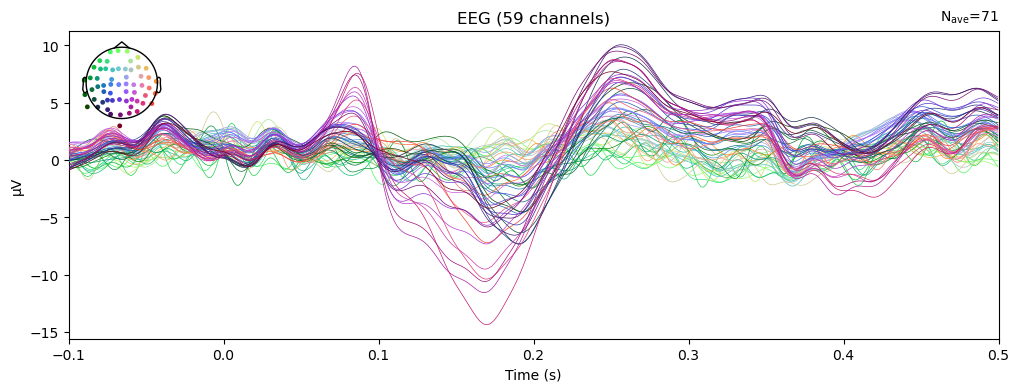

right visual


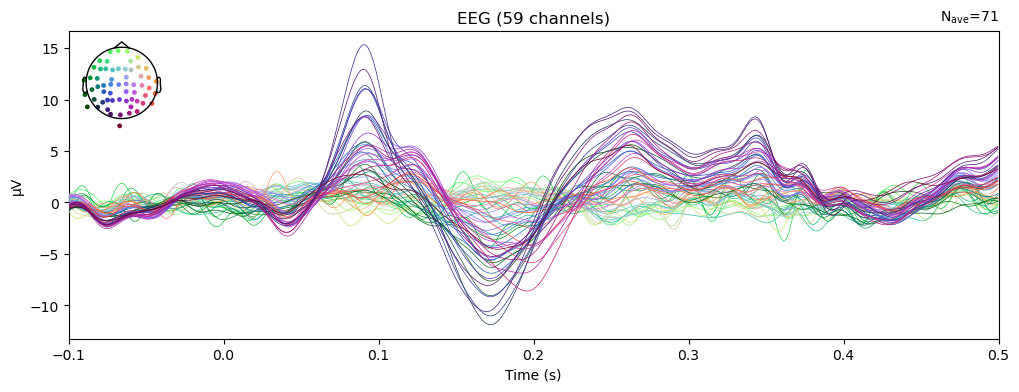

In [11]:
# Average within each condition
LV_evoked = epochs['left visual'].average()
RV_evoked = epochs['right visual'].average()

# Plot ERPs
print('left visual')
fig, ax = plt.subplots(1,1,figsize=(12,4))
fig = LV_evoked.plot(spatial_colors=True, xlim=(-0.1,0.5), axes=ax);

print('right visual')
fig, ax = plt.subplots(1,1,figsize=(12,4))
fig = RV_evoked.plot(spatial_colors=True, xlim=(-0.1,0.5), axes=ax);

We can also plot the scalp topographic maps for each condition.

left visual


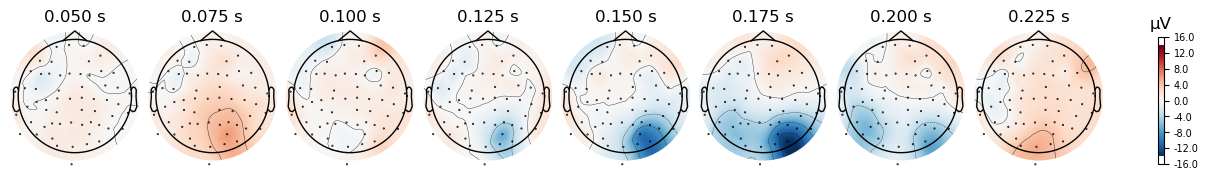

right visual


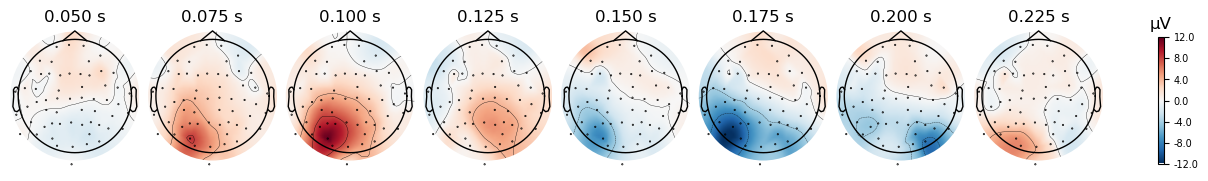

In [12]:
# Plot scalp topographies
print('left visual')
LV_evoked.plot_topomap(times=np.arange(0.05,0.25,0.025));
print('right visual')
RV_evoked.plot_topomap(times=np.arange(0.05,0.25,0.025));

Using the sensor layout from the previous notebook, we can choose a sensor that is clearly picking up a response to the visual stimuli. Here we are observing strong laterality, so we visualize two sensors: `EEG 056` and `EEG 057`. We will clearly see that that right- and left-presented stimuli are more strongly represented in the contralateral hemispheres.

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Using a threshold of 3.908741
stat_fun(H1): min=7.140652431346438e-06 max=25.713787000317087
Running initial clustering …
Found 6 clusters


/Users/snastase/miniconda3/envs/mne/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|████████████████████████████████████████████████| Permuting : 1023/1023 [00:00<00:00, 8368.84it/s]


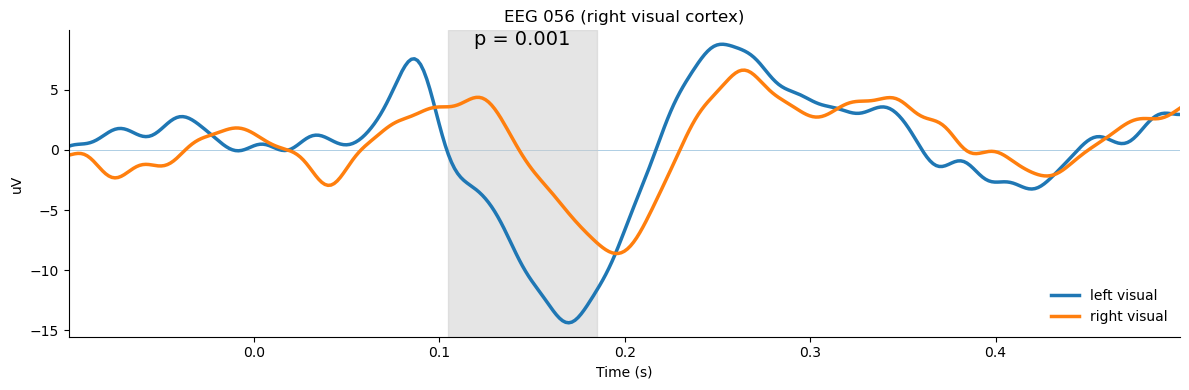

In [13]:
from mne.stats import permutation_cluster_test

# Extract data
eeg_056 = epochs.copy().pick_channels(['EEG 056'])
data = [eeg_056['left visual'].get_data().squeeze(), eeg_056['right visual'].get_data().squeeze()]
evokeds = [np.mean(data[0], axis=0) * 1e6, np.mean(data[1], axis=0) * 1e6]

# Using F-statistic as default
# F-stat = abs(t-stat ** 2)
F_obs, clusters, cluster_pv, H0 = permutation_cluster_test(data, n_permutations=1024, 
                                                           seed=47404, tail=1)

# Plotting
fig, ax = plt.subplots(1,1,figsize=(12,4))
ax.plot(epochs.times, evokeds[0], lw=2.5, label='left visual') # Cond: LV
ax.plot(epochs.times, evokeds[1], lw=2.5, label='right visual') # Cond: RV
#ax.plot(epochs.times, F_obs, lw=2, color='0.2', label='F-vals') # F-stats
ymin, ymax = ax.get_ylim()

# Plot clusters
for cluster, pval in zip(clusters, cluster_pv): 
    if pval < 0.05:
        center = epochs.times[cluster].mean()
        ax.fill_between(epochs.times[cluster], ymin, ymax, color='0.8', alpha=0.5)
        ax.annotate('p = %0.3f' %pval, (0,0), (center, ymax), ha='center', va='top', fontsize=14)
    
# Add details
ax.hlines(0, epochs.tmin, epochs.tmax, linewidth=0.5, alpha=0.5, zorder=0)
ax.set(xlim=(epochs.tmin, epochs.tmax), xlabel='Time (s)', ylim=(ymin, ymax), 
       ylabel='uV', title='EEG 056 (right visual cortex)')
ax.legend(loc=4, frameon=False)

sns.despine()
plt.tight_layout()
plt.show()

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Using a threshold of 3.908741
stat_fun(H1): min=2.537464183741758e-05 max=35.30948844830322
Running initial clustering …
Found 5 clusters


100%|████████████████████████████████████████████████| Permuting : 1023/1023 [00:00<00:00, 8246.08it/s]


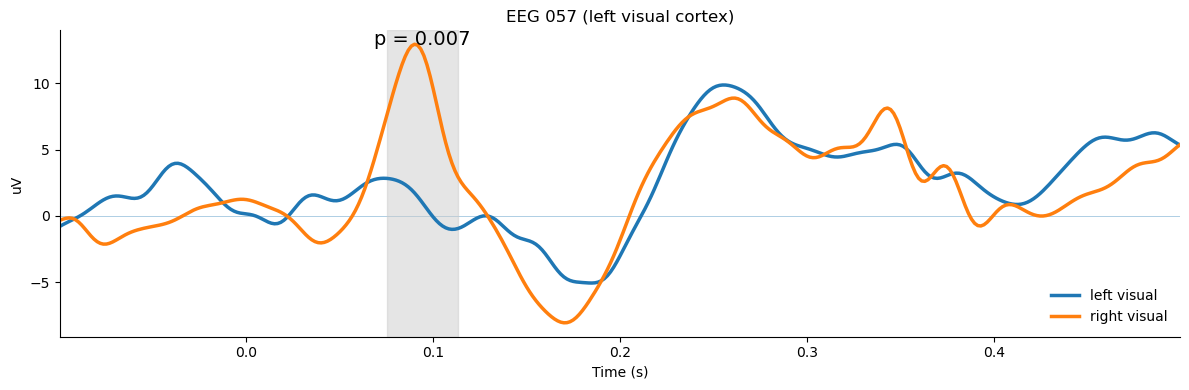

In [14]:
from mne.stats import permutation_cluster_test

# Extract data
eeg_057 = epochs.copy().pick_channels(['EEG 057'])
data = [eeg_057['left visual'].get_data().squeeze(), eeg_057['right visual'].get_data().squeeze()]
evokeds = [np.mean(data[0], axis=0) * 1e6, np.mean(data[1], axis=0) * 1e6]

# Using F-statistic as default
# F-stat = abs(t-stat ** 2)
F_obs, clusters, cluster_pv, H0 = permutation_cluster_test(data, n_permutations=1024, 
                                                           seed=47404, tail=1)

# Plotting
fig, ax = plt.subplots(1,1,figsize=(12,4))
ax.plot(epochs.times, evokeds[0], lw=2.5, label='left visual') # Cond: LV
ax.plot(epochs.times, evokeds[1], lw=2.5, label='right visual') # Cond: RV
#ax.plot(epochs.times, F_obs, lw=2, color='0.2', label='F-vals') # F-stats
ymin, ymax = ax.get_ylim()

# Plot clusters
for cluster, pval in zip(clusters, cluster_pv): 
    if pval < 0.05:
        center = epochs.times[cluster].mean()
        ax.fill_between(epochs.times[cluster], ymin, ymax, color='0.8', alpha=0.5)
        ax.annotate('p = %0.3f' %pval, (0,0), (center, ymax), ha='center', va='top', fontsize=14)
    
# Add details
ax.hlines(0, epochs.tmin, epochs.tmax, linewidth=0.5, alpha=0.5, zorder=0)
ax.set(xlim=(epochs.tmin, epochs.tmax), xlabel='Time (s)', ylim=(ymin, ymax), 
       ylabel='uV', title='EEG 057 (left visual cortex)')
ax.legend(loc=4, frameon=False)

sns.despine()
plt.tight_layout()
plt.show()

We can also compute the difference between the two ERPs.

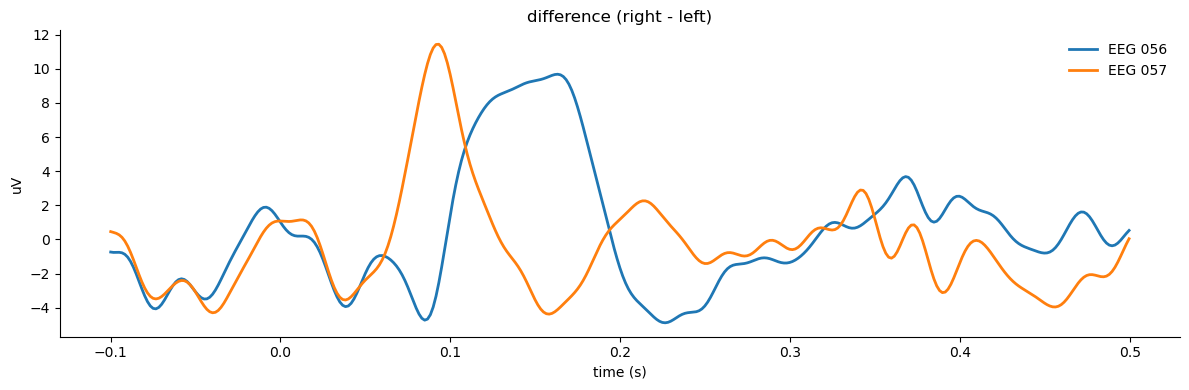

In [15]:
from mne import combine_evoked

# Compute difference wave
DV_evoked = combine_evoked([LV_evoked, RV_evoked], [-1,1])

# Plot difference waves
fig, ax = plt.subplots(1,1,figsize=(12,4))

for ch in ['EEG 056', 'EEG 057']:
    ax.plot(DV_evoked.times, DV_evoked.data[DV_evoked.ch_names.index(ch)] * 1e6, lw=2, label=ch)
    
ax.set(xlabel='time (s)', ylabel='uV', title='difference (right - left)')
ax.legend(loc=1, frameon=False)
sns.despine()
plt.tight_layout()
plt.show()